In [111]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import shutil
import yaml
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import datasets
from pathlib import Path
from datetime import datetime

In [107]:
BASE_DIR = Path(os.getcwd()).resolve().parent

data_dir = os.path.join(BASE_DIR, 'data')

models_dir = os.path.join(BASE_DIR, 'models')

train_data_dir= os.path.join(data_dir, 'train_data')

test_data_dir = os.path.join(data_dir, 'test_data')

# получение параметров для обучения модели
with open(Path.joinpath(BASE_DIR, 'params', 'process_model.yml')) as f:
    params = yaml.safe_load(f)

print(params)

{'test-size': 0.3, 'batch-size': 32, 'img-shape': 150, 'optim': 'SDG', 'learn-rate': 0.001, 'epochs': 10}


In [ ]:
# получение изображений с яндекс-диска

import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/TvlN8KDiWCHvVw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=data_dir)

In [13]:
# классы изображений

translate = {
    "cane": "собака", 
    "cavallo": "лошадь", 
    "elefante": "слон", 
    "farfalla": "бабочка", 
    "gallina": "курица", 
    "gatto": "кошка", 
    "mucca": "корова", 
    "pecora": "овца", 
    "scoiattolo": "белка",
    "ragno": "паук"
}

In [17]:
# смотрим сколько исходных данных в каждом классе
# создаем каталоги для тестовых данных

# очищаем каталог с тестовыми данными
if os.path.exists(test_data_dir):
    shutil.rmtree(test_data_dir)
    os.mkdir(test_data_dir)

train_data = {}
total_train_data = 0
for folder in os.listdir(train_data_dir):
    i = 0
    currentFolder = os.path.join(train_data_dir, folder)
    if os.path.isdir(currentFolder):
        for file in os.listdir(currentFolder):
            i += 1
        train_data[folder] = i
        os.mkdir(os.path.join(test_data_dir, folder))
print('Тренировочных данных по классам:')
for data in train_data.items():
    total_train_data += data[1]
    print(translate[data[0]] + ':', data[1])

Тренировочных данных по классам:
курица: 3098
паук: 4821
кошка: 1668
бабочка: 2112
корова: 1866
лошадь: 2623
собака: 4863
овца: 1820
белка: 1862
слон: 1446


In [18]:
# копируем часть тренировочных данных в тестовые наборы
# исходный набор тренировочных данных остается без изменений

test_data = {}
total_test_data = 0
for folder in os.listdir(train_data_dir):
    currentFolder = os.path.join(train_data_dir, folder)
    equalTestFolder = os.path.join(test_data_dir, folder)
    if os.path.isdir(currentFolder):
        filesList = os.listdir(currentFolder)
        part = round(train_data[folder] * params['tsize'])
        test_data[translate[folder]] = part
        for i in range(1, part):
            shutil.copy(os.path.join(currentFolder, filesList[i]), os.path.join(equalTestFolder, filesList[i]))
print('Тестовых данных по классам:')
for data in test_data.items():
    total_test_data += data[1]
    print(data[0] + ':', data[1])

Тестовых данных по классам:
курица: 929
паук: 1446
кошка: 500
бабочка: 634
корова: 560
лошадь: 787
собака: 1459
овца: 546
белка: 559
слон: 434


In [57]:
data_transforms = {
    'train_data': transforms.Compose([
        transforms.RandomResizedCrop(params['img-shape']),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test_data': transforms.Compose([
        transforms.RandomResizedCrop(params['img-shape']),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [67]:
def get_dataset(data_dir, data_transforms):
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train_data', 'test_data']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=params['batch-size'],
                                                  shuffle=True, 
                                                  num_workers=4)
                  for x in ['train_data', 'test_data']}
    
    classes = image_datasets['train_data'].classes

    return dataloaders["train_data"], dataloaders['test_data'], classes

In [71]:
# получаем преобразованные наборы данных

trainloader, testloader, classes = get_dataset(data_dir, data_transforms)

10


Calss: ragno


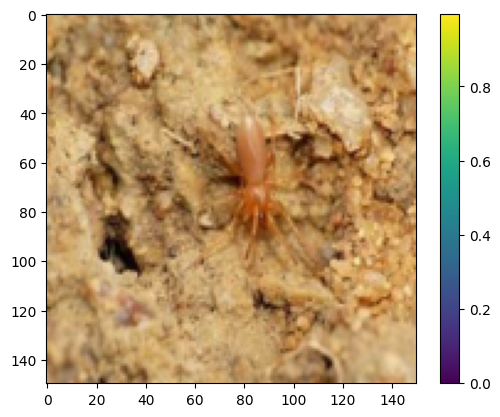

In [70]:
# посмотрим, как выглядит изображение
# получим кортеж изображений с помощью функции matplotlib next

dataiter = iter(trainloader)

sample_training_images, labels = next(dataiter)
img = sample_training_images[0] / 2 + 0.5
npimg = img.numpy()
   
plt.figure()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.colorbar()
plt.grid(False)

print('Class: ' + translate[classes[labels[0]]])

# на шкале справа отображается интенсивность пикселей

In [100]:
# создаем модель нейронной сети

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(18496, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [102]:
# определяем функецию потерь и оптимизатор

criterion = nn.CrossEntropyLoss()

if params['optim'] == 'SDG':
    optimizer = optim.SGD(net.parameters(), lr=params['learn-rate'], momentum=0.9)
else:
    optimizer = optim.Adam(net.parameters(), lr=params['learn-rate'], momentum=0.9)

In [103]:
# обучаем модель

for epoch in range(params['epochs']):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [116]:
# точность предсказания по классам

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {translate[classname]:5s} is {accuracy:.1f} %')

Accuracy for class: собака is 59.0 %
Accuracy for class: лошадь is 41.5 %
Accuracy for class: слон  is 21.0 %
Accuracy for class: бабочка is 70.5 %
Accuracy for class: курица is 56.7 %
Accuracy for class: кошка is 4.2 %
Accuracy for class: корова is 23.4 %
Accuracy for class: овца  is 26.1 %
Accuracy for class: паук  is 66.2 %
Accuracy for class: белка is 18.6 %


In [115]:
# сохраняем модель

torch.save(net.state_dict(), os.path.join(models_dir, 'model.pth'))

with open(os.path.join(models_dir, 'params.txt'), 'w') as f:
    f.write('date: ' + datetime.now().strftime("%d/%m/%Y %H:%M:%S") + '\n')
    f.write('params: ' + json.dumps(params))